In [1]:
from torch import nn
import torch

In [2]:
from torch.nn.utils.rnn import pad_sequence

In [3]:
import numpy as np

In [4]:
import pandas as pd

In [5]:
import os

In [6]:
from einops import rearrange

In [7]:
import random

In [8]:
from torch.utils.data import DataLoader

In [9]:
import torchvision.transforms as T

In [10]:
from skimage.util import random_noise

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [12]:
import torchaudio

C:\Users\aag12\anaconda3\envs\ml_env\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [13]:
from sklearn import preprocessing

In [14]:
from sklearn.model_selection import train_test_split

# Defining Dataseat

In [15]:
from datasets import load_dataset

In [16]:
from datasets import disable_caching
disable_caching()

In [17]:
# good_files = []
# for i in range(1, 6):
#     new_files = [f"0{i}/{fname.replace('npy', '')}mp3" for fname in os.listdir(f"../../subset_moodtheme/0{i}")]
#     good_files.extend(new_files)

# test_files = [f"00/{fname.replace('npy', '')}mp3" for fname in os.listdir("../../subset_moodtheme/00")]
# print(good_files)
# print(test_files)

In [18]:
with open("goodfiles.txt", 'r') as f:
    all_files = f.readlines()
all_files = [g.strip().replace("npy", 'mp3') for g in all_files if len(g.strip()) > 0]

In [19]:
all_files[:3]

['01/846501.mp3', '34/1288334.mp3', '98/1082098.mp3']

In [20]:
good_files, test_files = train_test_split(all_files, test_size=0.2)

In [21]:
len(good_files), len(test_files)

(2200, 551)

In [22]:
def files_to_labels(files):
    col_names = ['TRACK_ID',
     'ARTIST_ID',
     'ALBUM_ID',
     'PATH',
     'DURATION',
     'TAGS',
     'TAGS2',
     'TAGS3',
     'TAGS4',
     'TAGS5',
     'TAGS6',
     'TAGS7',
     'TAGS8',
     'TAGS9']
    MOODPATH = "../../../Downloads/autotagging_moodtheme.tsv.txt"
    df = pd.read_csv(MOODPATH, sep='\t', names=col_names)
    df = df[df["PATH"].isin(files)]
    inds = {'fast': 0,
     'sexy': 1,
     'mellow': 2,
     'heavy': 3,
     'horror': 4,
     'travel': 5,
     'holiday': 6,
     'groovy': 7,
     'funny': 8,
     'retro': 9,
     'hopeful': 10,
     'powerful': 11,
     'cool': 12,
     'nature': 13,
     'game': 14}

    final_labels = []
    for i in range(len(df)):
        curr = np.zeros(len(inds))
        moods = list(df.iloc[i])[5:]
        for theme in moods:
            if type(theme) == str and "mood" in theme:
                check = theme.split("---")[-1]
                if check in inds:
                    curr[inds[check]] = 1
            else:
                pass

        final_labels.append(curr)
    return final_labels

In [23]:
good_files[0]

'50/1387550.mp3'

In [24]:
195 * 12000 / 256

9140.625

In [25]:
10337 / 195

53.01025641025641

In [26]:
train_labels = files_to_labels(good_files)

In [27]:
test_labels = files_to_labels(test_files)

In [28]:
train_labels[:2]

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])]

In [29]:
# train_np_files = [("../../subset_moodtheme/" + g).replace(".mp3", ".npy") for g in good_files]
# test_np_files = [("../../subset_moodtheme/" + g).replace(".mp3", ".npy") for g in test_files]
train_np_files = ["../../mtg-jamendo-dataset/all_data/" + g.replace("mp3", "npy") for g in good_files]
test_np_files = ["../../mtg-jamendo-dataset/all_data/" + g.replace("mp3", "npy") for g in test_files]

In [30]:
train_np_files[:2], test_np_files[:2]

(['../../mtg-jamendo-dataset/all_data/50/1387550.npy',
  '../../mtg-jamendo-dataset/all_data/44/1344444.npy'],
 ['../../mtg-jamendo-dataset/all_data/21/1329121.npy',
  '../../mtg-jamendo-dataset/all_data/19/1124319.npy'])

In [31]:
import time

In [32]:
# SEQ_LEN = 10000
SEQ_LEN = 3000
# SEQ_LEN = 5000

# Dataset

In [33]:
from torchvision import transforms

In [363]:
class MusicDataset(torch.utils.data.Dataset):   
    def __init__(self, np_file_paths, labels, transforms, seq_len=10000, random_start=True, rolling=False, upsample_factor=10):
        self.seq_len = seq_len
        self.files = np_file_paths
        self.labels = labels
        self.transforms = transforms
        self.random_start = random_start
        self.upsample_factor = upsample_factor
        self.rolling = rolling
        
    def __len__(self):
        return len(self.files) * self.upsample_factor

    def __getitem__(self, index):
        if index > len(self.files) * self.upsample_factor:
            self.files[index]
        effective_index = index % len(self.files)
        fname = self.files[effective_index]
        x = np.load(fname)
        x = torch.from_numpy(x).float()
        rolls = []
        if self.rolling:
            cur_start = 0
            while cur_start < x.shape[1]:
                old_x = x[:,cur_start:cur_start + self.seq_len].unsqueeze(0)
                # clamp between bounds and scale
                compressed_x = (torch.clamp(old_x, min=-90, max=30) + 90) / 120

                new_x = self.transforms(compressed_x)
                cur_start += self.seq_len
                rolls.append(new_x)
        if self.random_start and x.shape[-1] > self.seq_len:
            # longer than seqlen, select random subset
            start = random.randint(0, x.shape[-1] - self.seq_len)
            x = x[:,start:start+self.seq_len]    
        else:
            x = x[:,:self.seq_len]

        old_x = x.unsqueeze(0)
        compressed_x = (torch.clamp(old_x, min=-90, max=30) + 90) / 120
        x = self.transforms(compressed_x)
        
#         item = {"input": x, "label_ids":[effective_index], "labels": torch.tensor(self.labels[effective_index]), "pixel_values":x}
        item = {"input": x, "rolls":rolls, "label_ids":[effective_index], "labels": torch.tensor(self.labels[effective_index]), "pixel_values":x}
#         item = {"input": x, "pixel_values":x}
        
        return item

In [364]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [456]:
# img_size = 224
img_size = 496
noise_composed = transforms.Compose([
#    transforms.Resize((img_size, img_size)),
       transforms.Resize((96, img_size)),
#     transforms.Normalize((0.5542), (0.1604)),
#     AddGaussianNoise(0., 0.04)
])
nonoise_composed = transforms.Compose([
#    transforms.Resize((img_size, img_size)),
       transforms.Resize((96, img_size)),
#     transforms.Normalize((0.5542), (0.1604))
])

In [460]:
# ft_train_dataset = MusicDataset(train_np_files, train_labels, noise_composed, seq_len=SEQ_LEN, random_start=True, upsample_factor=2)
# ft_test_dataset = MusicDataset(test_np_files, test_labels, nonoise_composed, seq_len=SEQ_LEN, random_start=False, upsample_factor=1)

ft_train_dataset = MusicDataset(train_np_files, train_labels, noise_composed, seq_len=SEQ_LEN, random_start=False, upsample_factor=2)
ft_test_dataset = MusicDataset(test_np_files, test_labels, nonoise_composed, seq_len=SEQ_LEN, random_start=False, upsample_factor=1)

In [461]:
ft_random_test_dataset = MusicDataset(test_np_files, test_labels, nonoise_composed, seq_len=SEQ_LEN, random_start=True, upsample_factor=1)

In [462]:
ft_roll_test_dataset = MusicDataset(test_np_files, test_labels, nonoise_composed, seq_len=SEQ_LEN, rolling=True, random_start=False, upsample_factor=1)
ft_roll_train_dataset = MusicDataset(train_np_files, train_labels, nonoise_composed, seq_len=SEQ_LEN, rolling=True, random_start=False, upsample_factor=1)

In [466]:
batch_size = 8

In [467]:
# train_dl = DataLoader(
#     pt_train_dataset,
#     batch_size=batch_size,
#     shuffle=True,
#     num_workers=0,
#     collate_fn=None,
#     pin_memory=False,
#  )

# test_dl = DataLoader(
#     pt_test_dataset,
#     batch_size=1,
#     shuffle=False,
#     num_workers=0,
#     collate_fn=None,
#     pin_memory=False,
#  )

## MAE

In [468]:
from vit_pytorch import ViT, MAE

In [469]:
from tqdm import tqdm
import torch.optim as optim

In [560]:
class MultiHeadedOutput(nn.Module):
    def __init__(self):
        super(MultiHeadedOutput, self).__init__()
        
        self.heads = nn.ModuleList([
            nn.Sequential(
                    nn.LayerNorm(512),
                    nn.Linear(512, 1024),
                    nn.LeakyReLU(), 
                    nn.Dropout(0.1),
                    nn.Linear(1024, 512),
                    nn.LeakyReLU(), 
                    nn.Linear(512, 1)
#                     nn.Linear(512, 2)
            ) for i in range(15)
#             ) for i in range(1)
        ])
        
    def forward(self, x: torch.Tensor):
        outputs = torch.stack([h(x) for h in self.heads], dim=1)
        return outputs

# Finetuning MAE for Task

In [561]:
h = MultiHeadedOutput()

In [562]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [563]:
# batch_size = 32
# batch_size = 64
batch_size = 128

In [564]:
ft_train_dl = DataLoader(
    ft_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )

ft_test_dl = DataLoader(
    ft_test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )


ft_random_test_dl = DataLoader(
    ft_random_test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )


In [599]:
from transformers import ViTConfig, ViTModel
from vit_pytorch import ViT, MAE

In [600]:
# v_for_downstream = ViT(
#     image_size = 224,
# #     patch_size = 32,
#     patch_size = 16,
#     num_classes = 15,
# #     dim = 1024,
#     dim = 512,
#     depth = 6,
#     heads = 8,
# #     mlp_dim = 2048,
#     mlp_dim = 512,
#     channels=1
# )

v_for_downstream = ViT(
    image_size = (96, 496),
#     patch_size = 32,
    patch_size = 16,
    num_classes = 15,
#     dim = 1024,
    dim = 512,
    depth = 4,
    heads = 6,
    mlp_dim = 1024,
#     mlp_dim = 512,
    channels=1
)
mae = MAE(
    encoder = v_for_downstream,
    masking_ratio = 0.75,   # the paper recommended 75% masked patches
    decoder_dim = 512,      # paper showed good results with just 512
    decoder_depth = 4       # anywhere from 1 to 8
)

In [601]:
# mae.load_state_dict(torch.load(f"./v2-maeklastnotbest-trained-vit-199.pt"))
mae.load_state_dict(torch.load(f"./v2-nonorm-maeklastnotbest-trained-vit-99.pt"))

<All keys matched successfully>

In [602]:
v_for_downstream = mae.encoder

In [603]:
v_for_downstream.mlp_head

Sequential(
  (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (1): Linear(in_features=512, out_features=15, bias=True)
)

In [604]:
def set_module_requires_grad_(module, requires_grad):
    for param in module.parameters():
        param.requires_grad = requires_grad
def freeze_all_layers_(module):
    set_module_requires_grad_(module, False)

In [605]:
freeze_all_layers_(v_for_downstream)

In [606]:
new_head = MultiHeadedOutput()

In [607]:
v_for_downstream.mlp_head = new_head

In [608]:
model = v_for_downstream

In [609]:
model = model.to(device)

In [610]:
from tqdm import tqdm
import torch.optim as optim

In [611]:
pos_weight = 1 / (torch.sum(torch.tensor(test_labels), dim=0) / len(test_labels))
pos_weight = 0 * torch.tensor(pos_weight) + 1
# pos_weight = pos_weight / 2

C:\Users\aag12\AppData\Local\Temp\ipykernel_67408\2238443094.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_weight = 0 * torch.tensor(pos_weight) + 1


In [612]:
pos_weight

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       dtype=torch.float64)

In [613]:
# optimizer = optim.AdamW(model.parameters(), lr=1e-3)
# optimizer = optim.AdamW(model.parameters(), lr=1e-4)
# optimizer = optim.AdamW(model.mlp_head.parameters(), lr=1e-3)
# optimizer = optim.AdamW(model.mlp_head.parameters(), lr=1e-2)
optimizer = optim.AdamW(model.mlp_head.parameters(), lr=1e-5, weight_decay=0.05, betas=(0.9, 0.95))
# optimizer = optim.AdamW(model.mlp_head.parameters(), lr=1e-3, weight_decay=0.1, betas=(0.9, 0.95))
# optimizer = optim.AdamW(model.mlp_head.parameters(), lr=5e-3, weight_decay=0.1, betas=(0.9, 0.95))
# criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight.to(device))
# criterions = [nn.BCEWithLogitsLoss(pos_weight=pos_weight[i].unsqueeze(0).to(device)) for i in range(15)]
criterions = [nn.BCEWithLogitsLoss() for i in range(15)]

In [614]:
def get_mask(targs):
    mask = []
    for val in targs:
        m = int(val) == 1 or random.random() < (1/15)
        mask.append(m)
    return mask

In [615]:
def get_total_loss(model, dataloader):
    total_loss = 0
    for batch_idx, data in enumerate(dataloader):
        inputs, labels = data['input'].to(device), data['labels'].to(device)

        outputs = model(inputs)

#         total_loss += criterion(outputs, labels.float())
        for i in range(15):
            criterion = criterions[i]
#             target = torch.zeros_like(outputs[:,i])
#             target = outputs[:,i,1]
#             target[:,labels[:,i].long()] = 1
#             for ind in range(len(target)):
#                 target[ind,labels[ind,i].long()] = 1
#             target = target.to(device)
#             total_loss += criterion(outputs[:,i], target)
#             total_loss += criterion(outputs[:,i], labels[:,i])
            total_loss += criterion(outputs[:,i,0], labels[:,i])
    return total_loss.item()

In [616]:
model.train()
ft_train_losses = []
ft_test_losses = []
for epoch in range(10):
# for epoch in range(5):
    total_loss = 0
#     for batch in train_loader:
    for batch_idx, data in tqdm(enumerate(ft_train_dl), total=len(ft_train_dl)):
        these_losses = []
        optimizer.zero_grad()
        inputs, labels = data['input'].to(device), data['labels'].to(device)
        outputs = model(inputs)
        
#         loss = criterion(outputs, labels)
        loss = 0
        for i in range(15):
            criterion = criterions[i]
#             target = torch.zeros_like(outputs[:,i])
#             target = outputs[:,i, 1]
#             target[:,labels[:,i].long()] = 1
#             for ind in range(len(target)):
#                 target[ind,labels[ind,i].long()] = 1
#             target = target.to(device)
#             loss += criterion(outputs[:,i,1], target)
            
            cur_outs = outputs[:,i,0]
            cur_targs = labels[:,i]
            
            num_pos = int(cur_targs.sum()) - 2
            num_neg_to_include = max(num_pos, 1)
            pos_outs = cur_outs[cur_targs == 1]
            neg_outs = cur_outs[cur_targs == 0]
            
            pos_targs = cur_targs[cur_targs == 1]
            neg_targs = cur_targs[cur_targs == 0]
            
            balanced_outs = torch.cat([pos_outs, neg_outs[:num_neg_to_include]])
            balanced_targs = torch.cat([pos_targs, neg_targs[:num_neg_to_include]])
            
            loss += criterion(cur_outs, cur_targs)
        loss.backward()
        optimizer.step()
        # for bookkeeping
        total_loss += loss.item()
        
    with torch.no_grad():
        train_total_loss = total_loss
        test_loss = get_total_loss(model, ft_test_dl)
        ft_train_losses.append(train_total_loss)
        ft_test_losses.append(test_loss)
        print(f"Epoch: {epoch}; Total Loss: {train_total_loss}; Test Loss: {test_loss}")
#         print(f"Epoch: {epoch}; Loss: {adjusted}; Test Loss: {test_loss}")

_ = model.eval()

100%|██████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:52<00:00,  1.51s/it]


Epoch: 0; Total Loss: 275.2723586360432; Test Loss: 3286.8731791973114


100%|██████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:51<00:00,  1.47s/it]


Epoch: 1; Total Loss: 172.3447522552451; Test Loss: 2299.70730856061


100%|██████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:49<00:00,  1.41s/it]


Epoch: 2; Total Loss: 136.80165603641458; Test Loss: 2098.4118934869766


100%|██████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:52<00:00,  1.49s/it]


Epoch: 3; Total Loss: 132.23753545196573; Test Loss: 2096.1393433213234


100%|██████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:36<00:00,  1.05s/it]


Epoch: 4; Total Loss: 132.05171116262014; Test Loss: 2098.40201343596


100%|██████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:37<00:00,  1.08s/it]


Epoch: 5; Total Loss: 131.86175676528364; Test Loss: 2099.343549117446


100%|██████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:36<00:00,  1.05s/it]


Epoch: 6; Total Loss: 132.00799734819643; Test Loss: 2094.456270650029


100%|██████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:36<00:00,  1.04s/it]


Epoch: 7; Total Loss: 131.89366911640778; Test Loss: 2096.745333123952


100%|██████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:36<00:00,  1.05s/it]


Epoch: 8; Total Loss: 131.9221305982404; Test Loss: 2097.7300713919103


100%|██████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:35<00:00,  1.03s/it]


Epoch: 9; Total Loss: 131.92146315888385; Test Loss: 2097.9754231087863


Text(0.5, 1.0, 'MAE Finetuning Train/Test Loss')

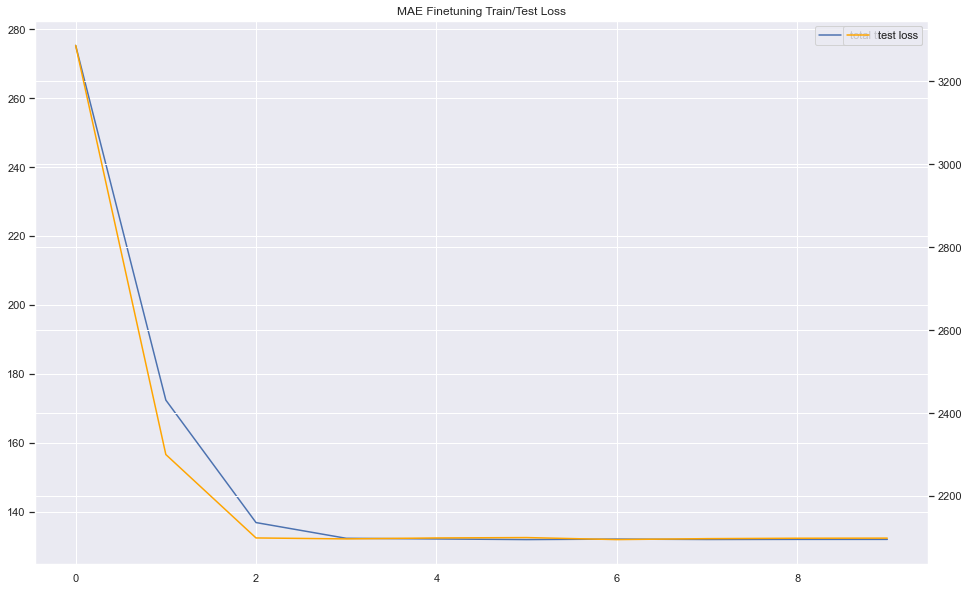

In [643]:
plt.figure(figsize=(16, 10))
ranger = list(range(len(ft_train_losses)))
sns.lineplot(x=ranger, y=ft_train_losses, label="total train loss", alpha=1)
# sns.lineplot(x=ranger, y=adjusted_train_losses, label="adjusted train loss")
ax2 = plt.twinx()
sns.lineplot(x=ranger, y=ft_test_losses, label="test loss", ax=ax2, color="orange", alpha=1)
# sns.lineplot(x=ranger, y=ft_test_losses, label="test loss", color="orange", alpha=0.5)
# plt.title("MAE v1: Finetuning Train/Test Loss")
plt.title("MAE Finetuning Train/Test Loss")
# plt.savefig("mae_v1.png")

In [644]:
outputs.shape

torch.Size([1, 15])

In [645]:
torch.cat(all_outputs).mean(dim=0)

tensor([0.0446, 0.0358, 0.0789, 0.0434, 0.0378, 0.0501, 0.0672, 0.0793, 0.0637,
        0.0981, 0.0787, 0.1072, 0.0853, 0.0823, 0.0920], device='cuda:0')

In [646]:
outputs.unsqueeze(0).shape

torch.Size([1, 1, 15])

In [677]:
model.eval()

combined_preds = []
combined_labels = []

with torch.no_grad():
#     a = model(dataset[2]['input'].to(device))
    total_correct = 0
    zero_correct = 0
    total_values = 0
    only_positives = [0, 0]
#     for batch_idx, data in enumerate(ft_test_dl):
#     for batch_idx, data in enumerate(ft_random_test_dl):
#     for batch_idx, data in enumerate(ft_roll_test_dataset):
#     for batch_idx, data in enumerate(ft_roll_train_dataset):
    for batch_idx, data in enumerate(ft_train_dl):
        if 'rolls' not in data or len(data['rolls']) == 0:
            inputs, labels = data['input'].to(device), data['labels'].to(device)
            outputs = model(inputs)
            outputs = torch.sigmoid(outputs[:,:,0])
        else:
            all_outputs = []
            labels = data['labels'].to(device)
            labels = labels.unsqueeze(0)
            for inputs in data['rolls']:
                cur_inputs = inputs.unsqueeze(0).to(device)
                outputs = model(cur_inputs)
                outputs = torch.sigmoid(outputs[:,:,0])
                all_outputs.append(outputs)
            outputs = torch.cat(all_outputs).mean(dim=0)
            outputs = outputs.unsqueeze(0)
#         combined_preds.append(outputs)
        combined_labels.append(labels)
        
        outlabels = torch.zeros_like(outputs)
#         outlabels = torch.argmax(outputs, dim=-1)
#         outlabels = torch.outputs
        combined_preds.append(outputs)
        outlabels[outputs >= 0.5] = 1
        outlabels[outputs < 0.5] = 0
        
        num_correct = torch.sum(outlabels == labels).item()
        
        num = len(labels) * 15
        
        total_correct += num_correct
        total_values += num
        zero_correct += torch.sum(labels == 0).item()
        
        only_positives[0] += torch.sum(labels).item()
        only_positives[1] += torch.sum(labels[labels == 1] == outlabels[labels == 1]).item()
        

print(total_correct / total_values)

print(f"{total_correct} out of {total_values}")

print("Performance on positive labels")

print(only_positives[1] / only_positives[0])

print(f"{only_positives[1]} out of {only_positives[0]}")

print("WHAT IF WE JUST PREDICTED ZERO")

print(zero_correct / total_values)

print(f"{zero_correct} out of {total_values}")

0.93
61380 out of 66000
Performance on positive labels
0.0
0 out of 4620.0
WHAT IF WE JUST PREDICTED ZERO
0.93
61380 out of 66000


In [678]:
all_preds = torch.cat(combined_preds)
all_labels = torch.cat(combined_labels)
all_preds.shape, all_labels.shape

(torch.Size([4400, 15]), torch.Size([4400, 15]))

In [679]:
len(ft_test_dataset)

551

In [680]:
from sklearn import metrics

In [681]:
torch.cat(combined_labels).sum(dim=0) / len(combined_labels) * 100

tensor([ 537.1429,  542.8571,  651.4286,  691.4286,  714.2857,  771.4286,
         805.7143,  897.1429,  960.0000,  982.8571, 1005.7143, 1068.5714,
        1160.0000, 1177.1429, 1234.2857], device='cuda:0', dtype=torch.float64)

In [687]:
aucs = []
for i in range(15):
    preds = all_preds[:,i].cpu()
    targs = all_labels[:,i].cpu()
#     fpr, tpr, thresholds = metrics.roc_curve(targs, preds, pos_label=1)
    fpr, tpr, thresholds = metrics.roc_curve(targs, preds, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    aucs.append(auc)
    print(f"Head: {i}; AUC: {auc:.03f}")

Head: 0; AUC: 0.595
Head: 1; AUC: 0.574
Head: 2; AUC: 0.556
Head: 3; AUC: 0.520
Head: 4; AUC: 0.571
Head: 5; AUC: 0.544
Head: 6; AUC: 0.542
Head: 7; AUC: 0.546
Head: 8; AUC: 0.561
Head: 9; AUC: 0.538
Head: 10; AUC: 0.562
Head: 11; AUC: 0.550
Head: 12; AUC: 0.548
Head: 13; AUC: 0.539
Head: 14; AUC: 0.539


In [683]:
good_aucs = [a for a in aucs if a > 0.5]

In [684]:
sum(good_aucs) / len(good_aucs)

0.5523238442791223

In [685]:
sum(aucs) / (len(aucs))

0.5523238442791223

In [657]:
from sklearn.metrics import roc_auc_score

In [658]:
roc_auc_score(targs, preds)

0.5355292050944225

In [659]:
import scikitplot as skplt
import matplotlib.pyplot as plt

In [660]:
from vit_pytorch.learnable_memory_vit import ViT, Adapter

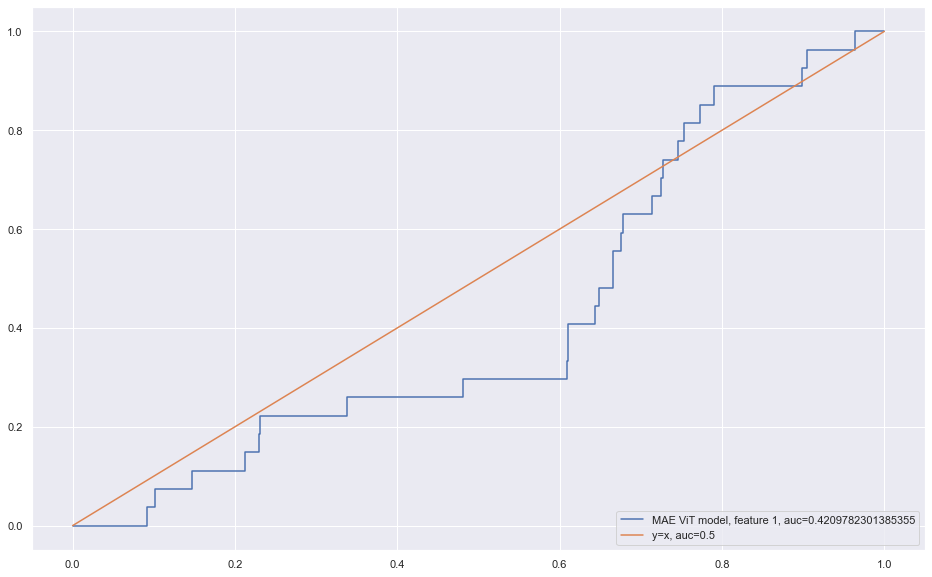

In [673]:
index = 1
plt.figure(figsize=(16, 10))
preds = all_preds[:,index].cpu()
targs = all_labels[:,index].cpu()
fpr, tpr, _ = metrics.roc_curve(targs, preds)
auc = metrics.roc_auc_score(targs, preds)
plt.plot(fpr,tpr,label=f"MAE ViT model, feature {index}, auc="+str(auc))

fpr, tpr, _ = metrics.roc_curve(targs, np.zeros_like(targs))
auc = metrics.roc_auc_score(targs, np.zeros_like(targs))
plt.plot(fpr,tpr,label="y=x, auc="+str(auc))

plt.legend(loc=4)
plt.show()

# SMALL HFACE TESTING

In [946]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [947]:
from transformers import ViTForImageClassification, ViTMAEForPreTraining, ViTMAEConfig, ViTFeatureExtractor

In [948]:
from transformers import Trainer, TrainingArguments
from transformers.trainer_utils import get_last_checkpoint

In [949]:
configuration = ViTMAEConfig(
                    image_size=224, 
                    num_channels=1, 
#                     norm_pix_loss=True, 
                    num_attention_heads=6, 
                    num_hidden_layers=3,
                    decoder_intermediate_size=1024,
                    intermediate_size=2048,
                    num_labels=15
)

In [971]:
v = ViTMAEForPreTraining.from_pretrained("hface_test_v0/final_mae.pt/")

loading configuration file hface_test_v0/final_mae.pt/config.json
Model config ViTMAEConfig {
  "architectures": [
    "ViTMAEForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.0,
  "decoder_hidden_size": 512,
  "decoder_intermediate_size": 1024,
  "decoder_num_attention_heads": 16,
  "decoder_num_hidden_layers": 8,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "mask_ratio": 0.75,
  "model_type": "vit_mae",
  "norm_pix_loss": false,
  "num_attention_heads": 6,
  "num_channels": 1,
  "num_hidden_layers": 3,
  "patch_size": 16,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.23.1"
}

loading weights file hface_test_v0/final_mae.pt/pytorch_model.bin
All model checkpoint weights were used when initializing ViTMAEForPreTraining.

All the weights of ViTMAEForPreTraining were initialized from the model checkpoint at hface_

In [972]:
vit_for_class = ViTForImageClassification(configuration)

In [973]:
vit_for_class.vit.load_state_dict(v.vit.state_dict())

<All keys matched successfully>

In [974]:
model = vit_for_class

In [1032]:
class MultiHeadedOutput(nn.Module):
    def __init__(self):
        super(MultiHeadedOutput, self).__init__()
        
        self.heads = nn.ModuleList([
            nn.Sequential(
                    nn.Linear(768, 512),
                    nn.LeakyReLU(), 
                    nn.Linear(512, 1)
            ) for i in range(15)
#             ) for i in range(1)
        ])
        
    def forward(self, x: torch.Tensor):
        outputs = torch.concat([h(x) for h in self.heads], dim=1)
        return outputs

In [976]:
model.classifier = MultiHeadedOutput().to(device)

In [977]:
# for p in model.classifier.parameters():
#     print(p)
#     print(p.requires_grad)

In [978]:
_ = model.to(device)

In [979]:
test_inp = ft_test_dataset[0]['input']

test_inp = torch.stack([test_inp, test_inp, test_inp]).to(device)

In [980]:
test_inp.shape, test_inp.device

(torch.Size([3, 1, 224, 224]), device(type='cuda', index=0))

In [981]:
model.device

device(type='cuda', index=0)

In [982]:
# model

In [983]:
model(test_inp)

ImageClassifierOutput(loss=None, logits=tensor([[ 0.9649,  0.2288,  0.4724,  0.4789,  0.3184, -0.4264,  0.1967,  0.2315,
         -0.2087, -0.4156, -0.1587, -0.2711,  0.0495, -0.5745, -0.4414],
        [ 0.9649,  0.2288,  0.4724,  0.4789,  0.3184, -0.4264,  0.1967,  0.2315,
         -0.2087, -0.4156, -0.1587, -0.2711,  0.0495, -0.5745, -0.4414],
        [ 0.9649,  0.2288,  0.4724,  0.4789,  0.3184, -0.4264,  0.1967,  0.2315,
         -0.2087, -0.4156, -0.1587, -0.2711,  0.0495, -0.5745, -0.4414]],
       device='cuda:0', grad_fn=<CatBackward0>), hidden_states=None, attentions=None)

In [984]:
! rm -rf hface_classtest_v0/

In [985]:
import torch.optim as optim

In [986]:
training_args = TrainingArguments(
    "hface_classtest_v0",
#     learning_rate=1.5e-4,
    learning_rate=5e-4,
    weight_decay=0.05,
#     num_train_epochs=10,
    num_train_epochs=5,
#     per_device_train_batch_size=8,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=1,
    logging_steps=10,
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=3,
    label_names=["labels"],
    disable_tqdm=True,
    report_to="none",
)

PyTorch: setting up devices


In [987]:
pos_weight = 1 / (torch.sum(torch.tensor(test_labels), dim=0) / len(test_labels))
# pos_weight = pos_weight / 2

In [988]:
pos_weight

tensor([22.0400, 36.7333, 21.1923, 18.3667, 14.8919, 16.6970, 13.7750, 12.5227,
        11.9783, 15.3056, 11.7234, 10.8039, 12.2444, 11.0200, 11.0200],
       dtype=torch.float64)

In [989]:
torch.clamp(torch.tensor(0.001), torch.tensor(0.05), torch.tensor(0.95))

tensor(0.0500)

In [990]:
pos_weight / 0.8

tensor([27.5500, 45.9167, 26.4904, 22.9583, 18.6149, 20.8712, 17.2187, 15.6534,
        14.9728, 19.1319, 14.6543, 13.5049, 15.3056, 13.7750, 13.7750],
       dtype=torch.float64)

In [991]:
class WeightedTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.rolling_mean_matrix = None
        self.max_factor = torch.tensor(1.5).to(device)
        self.min_factor = torch.tensor(0.8).to(device)
        
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(inputs.get("pixel_values"))
        logits = outputs.get('logits')
        preds = torch.sigmoid(torch.tensor(logits))
        preds[preds >= 0.5] = 1
        preds[preds < 0.5] = 0
        mean = preds.mean(dim=0)
        if self.rolling_mean_matrix is None:
            self.rolling_mean_matrix = []
        
        this_batch_weight = pos_weight.to(device)
        
        self.rolling_mean_matrix.append(mean)
        cur_means = torch.stack(self.rolling_mean_matrix).mean(dim=0)
        for i in range(cur_means.shape[0]):
            if cur_means[i] > 0:
                factor = torch.clamp((cur_means[i] / 0.5), self.min_factor, self.max_factor)
#                 this_batch_weight[i] = this_batch_weight[i] / factor
                this_batch_weight[i] = factor
        
        if len(self.rolling_mean_matrix) > 5:
            self.rolling_mean_matrix = self.rolling_mean_matrix[1:]
        
        
        loss_fct = nn.BCEWithLogitsLoss(pos_weight = this_batch_weight, reduction="sum")
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [1026]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

In [992]:
for p in model.vit.parameters():
    p.requires_grad = False

In [995]:
import transformers

In [997]:
optimizer = optim.AdamW(model.classifier.parameters(), lr=1e-3, weight_decay=0.05, betas=(0.9, 0.95))

In [1000]:
lr = transformers.get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=5 * len(ft_train_dataset))

In [1001]:
trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=ft_train_dataset,
        eval_dataset=ft_test_dataset,
        optimizers=[optimizer, lr]
    )

In [1002]:
# trainer.evaluate()
# # trainer.predict(ft_train_dataset)

In [1003]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 551
  Batch size = 1
The following columns in the evaluation set don't have a corresponding argument in `ViTForImageClassification.forward` and have been ignored: input. If input are not expected by `ViTForImageClassification.forward`,  you can safely ignore this message.
C:\Users\aag12\AppData\Local\Temp\ipykernel_16152\3559753343.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = torch.sigmoid(torch.tensor(logits))


{'eval_loss': 15.265395311984737, 'eval_runtime': 5.0218, 'eval_samples_per_second': 109.721, 'eval_steps_per_second': 109.721}


{'eval_loss': 15.265395311984737,
 'eval_runtime': 5.0218,
 'eval_samples_per_second': 109.721,
 'eval_steps_per_second': 109.721}

In [1004]:
# preds = trainer.predict(ft_test_dataset)

In [1005]:
trainer.train()

***** Running training *****
  Num examples = 4400
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 690
The following columns in the training set don't have a corresponding argument in `ViTForImageClassification.forward` and have been ignored: input. If input are not expected by `ViTForImageClassification.forward`,  you can safely ignore this message.
C:\Users\aag12\AppData\Local\Temp\ipykernel_16152\3559753343.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = torch.sigmoid(torch.tensor(logits))


{'loss': 1430.5021, 'learning_rate': 0.0009995454545454546, 'epoch': 0.07}
{'loss': 694.3522, 'learning_rate': 0.0009990909090909091, 'epoch': 0.14}
{'loss': 965.9942, 'learning_rate': 0.0009986363636363637, 'epoch': 0.22}
{'loss': 680.2544, 'learning_rate': 0.0009981818181818182, 'epoch': 0.29}
{'loss': 471.8683, 'learning_rate': 0.0009977272727272727, 'epoch': 0.36}
{'loss': 728.0873, 'learning_rate': 0.0009972727272727273, 'epoch': 0.43}
{'loss': 461.1983, 'learning_rate': 0.0009968181818181818, 'epoch': 0.51}
{'loss': 636.2798, 'learning_rate': 0.0009963636363636364, 'epoch': 0.58}
{'loss': 600.5546, 'learning_rate': 0.000995909090909091, 'epoch': 0.65}
{'loss': 458.4179, 'learning_rate': 0.0009954545454545455, 'epoch': 0.72}
{'loss': 623.5829, 'learning_rate': 0.000995, 'epoch': 0.8}
{'loss': 506.1412, 'learning_rate': 0.0009945454545454546, 'epoch': 0.87}
{'loss': 564.8225, 'learning_rate': 0.000994090909090909, 'epoch': 0.94}


***** Running Evaluation *****
  Num examples = 551
  Batch size = 1
The following columns in the evaluation set don't have a corresponding argument in `ViTForImageClassification.forward` and have been ignored: input. If input are not expected by `ViTForImageClassification.forward`,  you can safely ignore this message.
Saving model checkpoint to hface_classtest_v0\checkpoint-138
Configuration saved in hface_classtest_v0\checkpoint-138\config.json
Model weights saved in hface_classtest_v0\checkpoint-138\pytorch_model.bin


{'eval_loss': 18.80177927534273, 'eval_runtime': 4.4643, 'eval_samples_per_second': 123.424, 'eval_steps_per_second': 123.424, 'epoch': 1.0}


C:\Users\aag12\AppData\Local\Temp\ipykernel_16152\3559753343.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = torch.sigmoid(torch.tensor(logits))


{'loss': 530.0035, 'learning_rate': 0.0009936363636363636, 'epoch': 1.01}
{'loss': 532.9232, 'learning_rate': 0.0009931818181818182, 'epoch': 1.09}
{'loss': 533.319, 'learning_rate': 0.0009927272727272727, 'epoch': 1.16}
{'loss': 542.5402, 'learning_rate': 0.0009922727272727273, 'epoch': 1.23}
{'loss': 475.969, 'learning_rate': 0.0009918181818181818, 'epoch': 1.3}
{'loss': 611.4777, 'learning_rate': 0.0009913636363636364, 'epoch': 1.38}
{'loss': 586.8733, 'learning_rate': 0.000990909090909091, 'epoch': 1.45}
{'loss': 548.6574, 'learning_rate': 0.0009904545454545455, 'epoch': 1.52}
{'loss': 584.7776, 'learning_rate': 0.00099, 'epoch': 1.59}
{'loss': 497.8968, 'learning_rate': 0.0009895454545454545, 'epoch': 1.67}
{'loss': 596.6399, 'learning_rate': 0.000989090909090909, 'epoch': 1.74}
{'loss': 648.8338, 'learning_rate': 0.0009886363636363636, 'epoch': 1.81}
{'loss': 459.3218, 'learning_rate': 0.0009881818181818182, 'epoch': 1.88}
{'loss': 639.9444, 'learning_rate': 0.0009877272727272727

***** Running Evaluation *****
  Num examples = 551
  Batch size = 1
The following columns in the evaluation set don't have a corresponding argument in `ViTForImageClassification.forward` and have been ignored: input. If input are not expected by `ViTForImageClassification.forward`,  you can safely ignore this message.
Saving model checkpoint to hface_classtest_v0\checkpoint-276
Configuration saved in hface_classtest_v0\checkpoint-276\config.json
Model weights saved in hface_classtest_v0\checkpoint-276\pytorch_model.bin


{'eval_loss': 19.2113256032601, 'eval_runtime': 4.5308, 'eval_samples_per_second': 121.611, 'eval_steps_per_second': 121.611, 'epoch': 2.0}


C:\Users\aag12\AppData\Local\Temp\ipykernel_16152\3559753343.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = torch.sigmoid(torch.tensor(logits))


{'loss': 580.7096, 'learning_rate': 0.0009872727272727273, 'epoch': 2.03}
{'loss': 554.9038, 'learning_rate': 0.0009868181818181818, 'epoch': 2.1}
{'loss': 578.0779, 'learning_rate': 0.0009863636363636363, 'epoch': 2.17}
{'loss': 487.4337, 'learning_rate': 0.000985909090909091, 'epoch': 2.25}
{'loss': 643.2579, 'learning_rate': 0.0009854545454545454, 'epoch': 2.32}
{'loss': 532.3359, 'learning_rate': 0.000985, 'epoch': 2.39}
{'loss': 550.7402, 'learning_rate': 0.0009845454545454545, 'epoch': 2.46}
{'loss': 560.4978, 'learning_rate': 0.000984090909090909, 'epoch': 2.54}
{'loss': 570.1198, 'learning_rate': 0.0009836363636363636, 'epoch': 2.61}
{'loss': 610.0007, 'learning_rate': 0.0009831818181818182, 'epoch': 2.68}
{'loss': 539.0846, 'learning_rate': 0.0009827272727272727, 'epoch': 2.75}
{'loss': 555.0501, 'learning_rate': 0.0009822727272727272, 'epoch': 2.83}
{'loss': 600.8706, 'learning_rate': 0.0009818181818181818, 'epoch': 2.9}
{'loss': 541.3888, 'learning_rate': 0.00098136363636363

***** Running Evaluation *****
  Num examples = 551
  Batch size = 1
The following columns in the evaluation set don't have a corresponding argument in `ViTForImageClassification.forward` and have been ignored: input. If input are not expected by `ViTForImageClassification.forward`,  you can safely ignore this message.
Saving model checkpoint to hface_classtest_v0\checkpoint-414
Configuration saved in hface_classtest_v0\checkpoint-414\config.json
Model weights saved in hface_classtest_v0\checkpoint-414\pytorch_model.bin


{'eval_loss': 21.09870660231369, 'eval_runtime': 4.5148, 'eval_samples_per_second': 122.043, 'eval_steps_per_second': 122.043, 'epoch': 3.0}


C:\Users\aag12\AppData\Local\Temp\ipykernel_16152\3559753343.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = torch.sigmoid(torch.tensor(logits))


{'loss': 547.2057, 'learning_rate': 0.0009809090909090909, 'epoch': 3.04}
{'loss': 531.8199, 'learning_rate': 0.0009804545454545454, 'epoch': 3.12}
{'loss': 588.2907, 'learning_rate': 0.00098, 'epoch': 3.19}
{'loss': 548.5395, 'learning_rate': 0.0009795454545454545, 'epoch': 3.26}
{'loss': 491.8589, 'learning_rate': 0.000979090909090909, 'epoch': 3.33}
{'loss': 641.0481, 'learning_rate': 0.0009786363636363636, 'epoch': 3.41}
{'loss': 558.2191, 'learning_rate': 0.0009781818181818181, 'epoch': 3.48}
{'loss': 547.6961, 'learning_rate': 0.000977727272727273, 'epoch': 3.55}
{'loss': 563.2959, 'learning_rate': 0.0009772727272727272, 'epoch': 3.62}
{'loss': 529.456, 'learning_rate': 0.0009768181818181818, 'epoch': 3.7}
{'loss': 545.2715, 'learning_rate': 0.0009763636363636363, 'epoch': 3.77}
{'loss': 558.7799, 'learning_rate': 0.000975909090909091, 'epoch': 3.84}
{'loss': 556.7791, 'learning_rate': 0.0009754545454545455, 'epoch': 3.91}
{'loss': 648.9919, 'learning_rate': 0.000975, 'epoch': 3.

***** Running Evaluation *****
  Num examples = 551
  Batch size = 1
The following columns in the evaluation set don't have a corresponding argument in `ViTForImageClassification.forward` and have been ignored: input. If input are not expected by `ViTForImageClassification.forward`,  you can safely ignore this message.
Saving model checkpoint to hface_classtest_v0\checkpoint-552
Configuration saved in hface_classtest_v0\checkpoint-552\config.json
Model weights saved in hface_classtest_v0\checkpoint-552\pytorch_model.bin
Deleting older checkpoint [hface_classtest_v0\checkpoint-138] due to args.save_total_limit


{'eval_loss': 18.764401430564128, 'eval_runtime': 4.6555, 'eval_samples_per_second': 118.355, 'eval_steps_per_second': 118.355, 'epoch': 4.0}


C:\Users\aag12\AppData\Local\Temp\ipykernel_16152\3559753343.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = torch.sigmoid(torch.tensor(logits))


{'loss': 453.8943, 'learning_rate': 0.0009745454545454545, 'epoch': 4.06}
{'loss': 715.5841, 'learning_rate': 0.0009740909090909092, 'epoch': 4.13}
{'loss': 553.5013, 'learning_rate': 0.0009736363636363637, 'epoch': 4.2}
{'loss': 510.041, 'learning_rate': 0.0009731818181818181, 'epoch': 4.28}
{'loss': 797.363, 'learning_rate': 0.0009727272727272728, 'epoch': 4.35}
{'loss': 458.838, 'learning_rate': 0.0009722727272727273, 'epoch': 4.42}
{'loss': 644.5192, 'learning_rate': 0.0009718181818181819, 'epoch': 4.49}
{'loss': 650.0948, 'learning_rate': 0.0009713636363636363, 'epoch': 4.57}
{'loss': 482.7236, 'learning_rate': 0.000970909090909091, 'epoch': 4.64}
{'loss': 598.9382, 'learning_rate': 0.0009704545454545455, 'epoch': 4.71}
{'loss': 507.3214, 'learning_rate': 0.0009699999999999999, 'epoch': 4.78}
{'loss': 577.7528, 'learning_rate': 0.0009695454545454546, 'epoch': 4.86}
{'loss': 611.0751, 'learning_rate': 0.0009690909090909091, 'epoch': 4.93}


***** Running Evaluation *****
  Num examples = 551
  Batch size = 1
The following columns in the evaluation set don't have a corresponding argument in `ViTForImageClassification.forward` and have been ignored: input. If input are not expected by `ViTForImageClassification.forward`,  you can safely ignore this message.


{'loss': 490.9439, 'learning_rate': 0.0009686363636363637, 'epoch': 5.0}


Saving model checkpoint to hface_classtest_v0\checkpoint-690
Configuration saved in hface_classtest_v0\checkpoint-690\config.json
Model weights saved in hface_classtest_v0\checkpoint-690\pytorch_model.bin
Deleting older checkpoint [hface_classtest_v0\checkpoint-276] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from hface_classtest_v0\checkpoint-552 (score: 18.764401430564128).


{'eval_loss': 23.409171355434093, 'eval_runtime': 4.6563, 'eval_samples_per_second': 118.334, 'eval_steps_per_second': 118.334, 'epoch': 5.0}
{'train_runtime': 145.102, 'train_samples_per_second': 151.617, 'train_steps_per_second': 4.755, 'train_loss': 585.8775100486866, 'epoch': 5.0}


TrainOutput(global_step=690, training_loss=585.8775100486866, metrics={'train_runtime': 145.102, 'train_samples_per_second': 151.617, 'train_steps_per_second': 4.755, 'train_loss': 585.8775100486866, 'epoch': 5.0})

In [1006]:
# trainer.evaluate(ft_train_dataset)

In [1007]:
# trainer.evaluate(ft_test_dataset)

In [1008]:
test_preds = trainer.predict(ft_test_dataset)

***** Running Prediction *****
  Num examples = 551
  Batch size = 1
The following columns in the test set don't have a corresponding argument in `ViTForImageClassification.forward` and have been ignored: input. If input are not expected by `ViTForImageClassification.forward`,  you can safely ignore this message.
C:\Users\aag12\AppData\Local\Temp\ipykernel_16152\3559753343.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = torch.sigmoid(torch.tensor(logits))


In [1009]:
test_preds.metrics

{'test_loss': 18.81619772479288,
 'test_runtime': 5.3725,
 'test_samples_per_second': 102.56,
 'test_steps_per_second': 102.56}

In [1010]:
labels = torch.stack([ft_test_dataset[i]['labels'] for i in range(len(ft_test_dataset))])

In [1011]:
labels.shape

torch.Size([551, 15])

In [1012]:
labels.sum(dim=0)

tensor([25., 15., 26., 30., 37., 33., 40., 44., 46., 36., 47., 51., 45., 50.,
        50.], dtype=torch.float64)

In [1013]:
preds = torch.sigmoid(torch.tensor(test_preds.predictions))

preds[preds >= 0.5] = 1
preds[preds < 0.5] = 0

In [1014]:
num_correct = torch.sum(preds == labels).item()
num = len(labels) * 15
zero_correct = torch.sum(labels == 0).item()

In [1015]:
num_correct / num

0.7805202661826981

In [1016]:
preds = torch.sigmoid(torch.tensor(test_preds.predictions))

In [1017]:
preds

tensor([[0.4653, 0.5330, 0.4733,  ..., 0.4504, 0.4625, 0.4772],
        [0.4664, 0.5317, 0.4913,  ..., 0.4770, 0.4662, 0.4790],
        [0.4097, 0.5536, 0.4759,  ..., 0.3993, 0.4166, 0.4968],
        ...,
        [0.4280, 0.5448, 0.4572,  ..., 0.4366, 0.4440, 0.4826],
        [0.2717, 0.5389, 0.4200,  ..., 0.3869, 0.3801, 0.4872],
        [0.4440, 0.5441, 0.4650,  ..., 0.4292, 0.4570, 0.4855]])

In [1018]:
preds[preds >= 0.5] = 1
preds[preds < 0.5] = 0

In [1019]:
preds

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

In [1020]:
torch.sum(labels[labels == 1] == preds[labels == 1]).item() / torch.sum(labels).item()

0.12173913043478261

In [1021]:
all_preds = preds
all_labels = labels

In [1022]:
from sklearn import metrics

In [1023]:
all_preds.mean(dim=0)

tensor([0.0000, 0.9891, 0.0163, 0.0000, 0.0000, 0.9256, 0.0000, 0.0000, 0.0000,
        0.2958, 0.2577, 0.0000, 0.0000, 0.0000, 0.0181])

In [1024]:
aucs = []
for i in range(15):
    cur_preds = all_preds[:,i].cpu()
    targs = all_labels[:,i].cpu()
#     fpr, tpr, thresholds = metrics.roc_curve(targs, preds, pos_label=1)
    fpr, tpr, thresholds = metrics.roc_curve(targs, cur_preds, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    aucs.append(auc)
    print(f"Head: {i}; AUC: {auc}")

Head: 0; AUC: 0.5
Head: 1; AUC: 0.5055970149253731
Head: 2; AUC: 0.49142857142857144
Head: 3; AUC: 0.5
Head: 4; AUC: 0.5
Head: 5; AUC: 0.4912249912249912
Head: 6; AUC: 0.5
Head: 7; AUC: 0.5
Head: 8; AUC: 0.5
Head: 9; AUC: 0.5646440129449839
Head: 10; AUC: 0.47543059777102337
Head: 11; AUC: 0.5
Head: 12; AUC: 0.5
Head: 13; AUC: 0.5
Head: 14; AUC: 0.49001996007984033


In [1025]:
sum(aucs) / len(aucs)

0.5012230098916522